In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/#Университет/Курс по ИИ 2024/Обработка видео 2024

Mounted at /content/drive/
/content/drive/MyDrive/#Университет/Курс по ИИ 2024/Обработка видео 2024


In [ ]:
import cv2
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 120

In [ ]:
from tqdm.notebook import trange, tqdm

In [ ]:
# i_frames is sorted
def get_frames(video, i_frames, thresholding=False, threshold=75):
  if type(video) is str:
    cap = cv2.VideoCapture(video)
  else:
    cap = video
  i_frame = 0
  frames = []
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print('Видео закончилось')
      break
    if i_frame in i_frames:
      image = 255 - cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      if thresholding:
        ret, image = cv2.threshold(image,threshold,255,cv2.THRESH_BINARY)
      frames.append(image)
    i_frame += 1
    if len(frames) == len(i_frames):
      return frames

In [ ]:
cap = cv2.VideoCapture("1.mp4")
fps = float(cap.get(cv2.CAP_PROP_FPS))
frame_time = 1 / fps
last_frame_i = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1

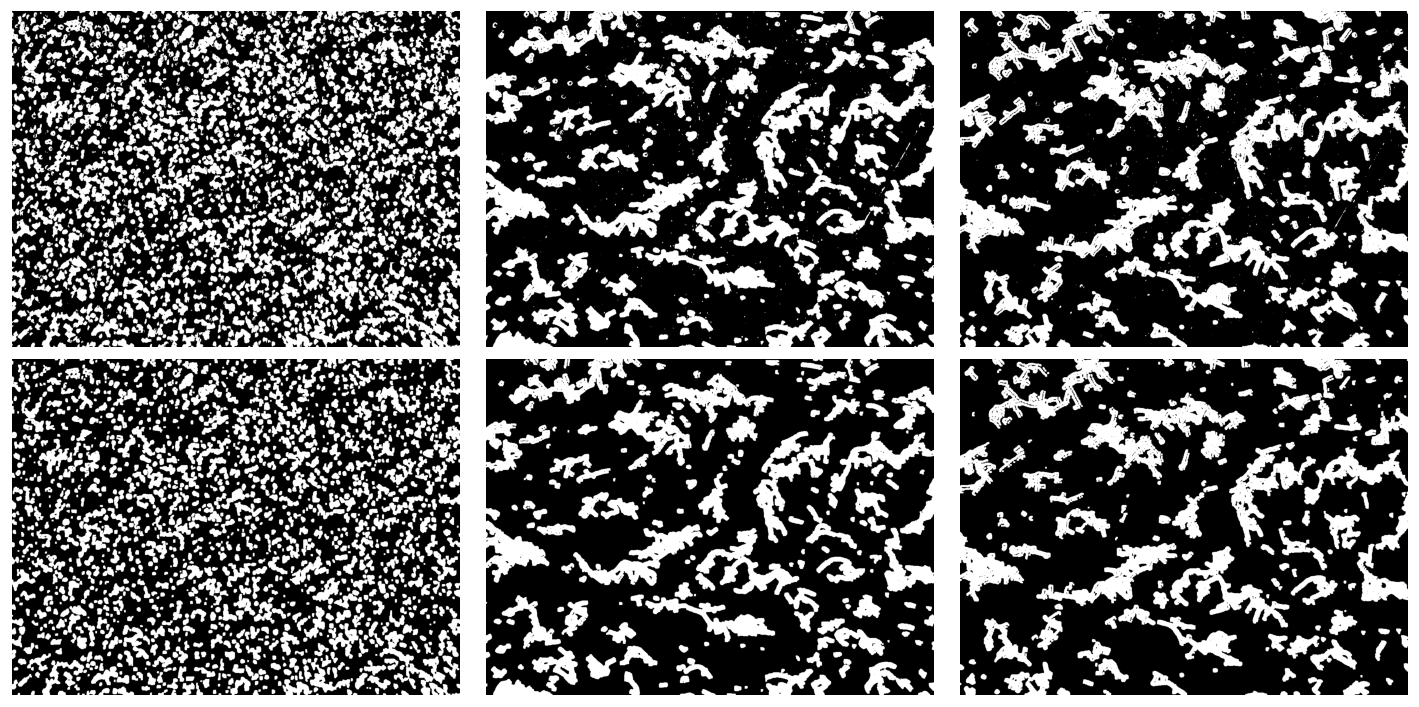

In [ ]:
cap = cv2.VideoCapture("1.mp4")
images = get_frames(cap, [0, int(last_frame_i / 3), last_frame_i], thresholding=True, threshold=80)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
kernel = np.ones((5,5),np.uint8)

for i, image in enumerate(images):
    axs[0][i].imshow(image, cmap="gray", vmin=0, vmax=255)
    axs[0][i].axis('off')
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    axs[1][i].imshow(image, cmap="gray", vmin=0, vmax=255)
    axs[1][i].axis('off')

plt.tight_layout()
plt.show()

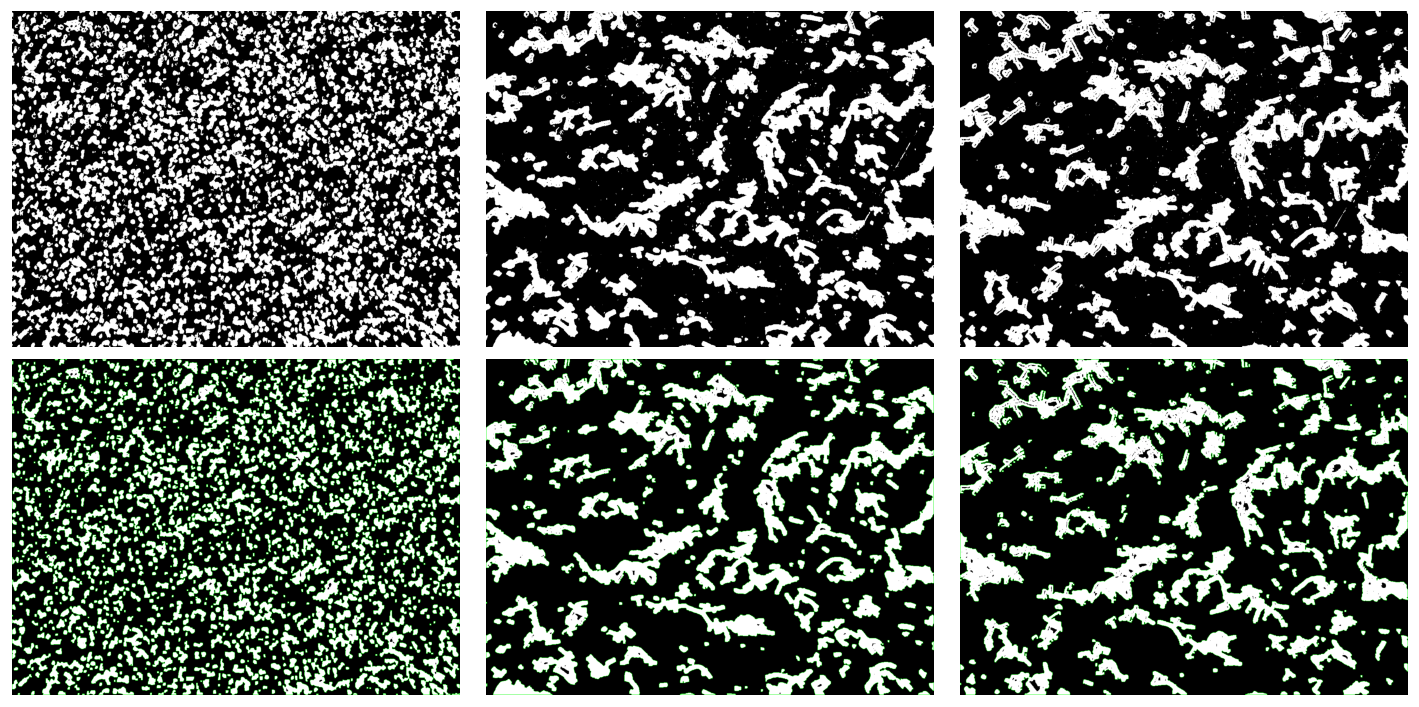

In [ ]:
cap = cv2.VideoCapture("1.mp4")
images = get_frames(cap, [0, int(last_frame_i / 3), last_frame_i], thresholding=True, threshold=80)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
kernel = np.ones((5,5),np.uint8)

for i, image in enumerate(images):
    axs[0][i].imshow(image, cmap="gray", vmin=0, vmax=255)
    axs[0][i].axis('off')
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
    im_сopy = image.copy()
    im_сopy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    im_сopy = cv2.drawContours(im_сopy, contours, -1, (0,255,0), 1)
    axs[1][i].imshow(im_сopy)
    axs[1][i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def draw_min_area_rect(image, rect):
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.polylines(image, [box], True, (0, 255, 0), 2)

<ipython-input-6-59edf3d28118>:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


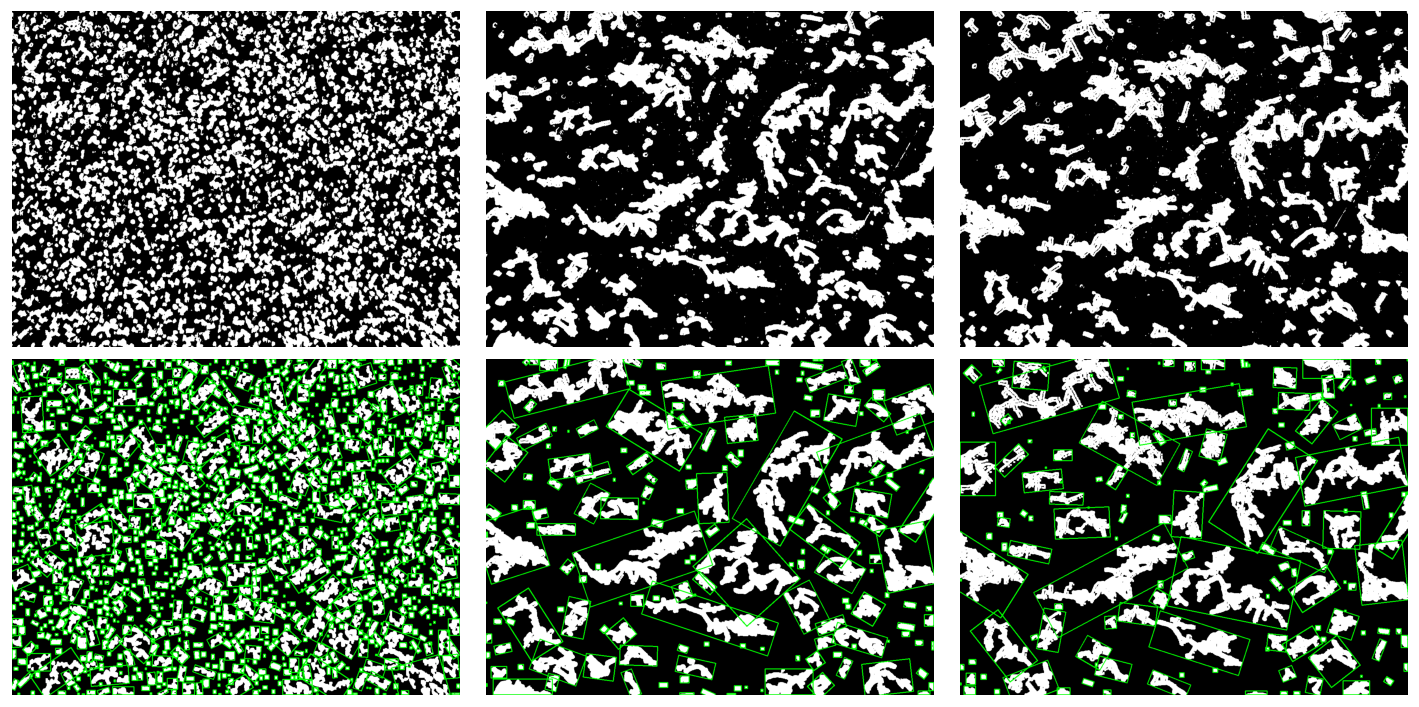

In [ ]:
cap = cv2.VideoCapture("1.mp4")
images = get_frames(cap, [0, int(last_frame_i / 3), last_frame_i], thresholding=True, threshold=80)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
kernel = np.ones((5,5),np.uint8)

for i, image in enumerate(images):
    axs[0][i].imshow(image, cmap="gray", vmin=0, vmax=255)
    axs[0][i].axis('off')
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
    im_сopy = image.copy()
    im_сopy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # im_сopy = cv2.drawContours(im_сopy, contours, -1, (0,255,0), 1)
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        draw_min_area_rect(im_сopy, rect)
    axs[1][i].imshow(im_сopy)
    axs[1][i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def width_of_rbc(cnt):
  rect = cv2.minAreaRect(cnt)
  width = max(rect[1])
  return width


def area_of_aggregate(cnt):
    area = cv2.contourArea(cnt)
    return area

In [ ]:
cells_num = 3346 # среднее кол-во клеток на изображениях

cap = cv2.VideoCapture("1.mp4")
fps = float(cap.get(cv2.CAP_PROP_FPS))
frame_time = 1 / fps
last_frame_i = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
i_frame = 0
step = 5
all_frames_indx = list(range(0, last_frame_i + 1, step))

kernel = np.ones((5,5),np.uint8)

times = np.zeros(len(all_frames_indx))
av_areas = np.zeros(len(all_frames_indx))
av_lengths = np.zeros(len(all_frames_indx))
av_counts = np.zeros(len(all_frames_indx))

i = 0
with tqdm(total=len(all_frames_indx)) as pbar:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print('Видео закончилось')
            break

        if not i_frame in all_frames_indx:
            i_frame += 1
            continue

        image = 255 - cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, image = cv2.threshold(image, 80, 255, cv2.THRESH_BINARY)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры

        times[i] = frame_time * i_frame
        count = len(contours)
        lens = 0
        areas = 0
        for cnt in contours:
            lens += width_of_rbc(cnt)
            areas += area_of_aggregate(cnt)
        av_lengths[i] = lens / count
        av_areas[i] = areas / count
        av_counts[i] = cells_num / count

        i += 1
        i_frame += 1
        pbar.update(1)

  0%|          | 0/285 [00:00<?, ?it/s]

Видео закончилось


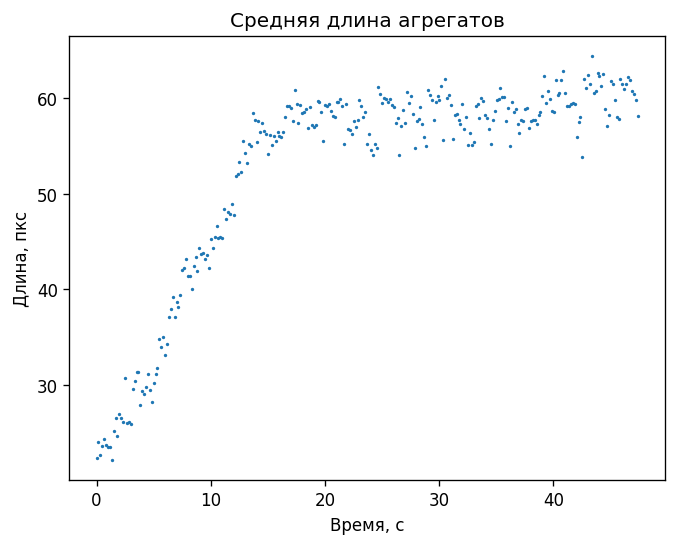

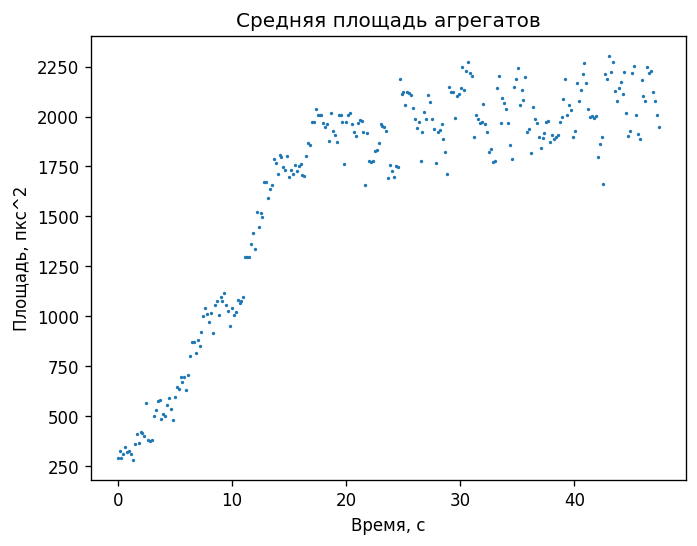

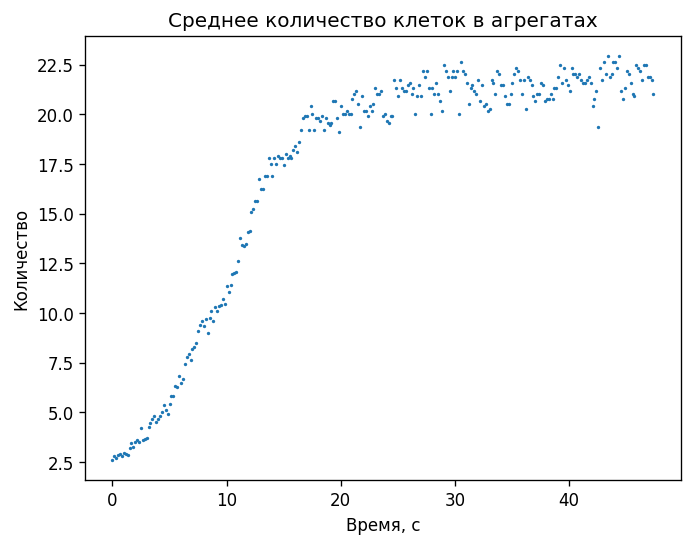

In [ ]:
plt.scatter(times, av_lengths, s=1)
plt.title("Средняя длина агрегатов")
plt.xlabel("Время, с")
plt.ylabel("Длина, пкс")
plt.show()

plt.scatter(times, av_areas, s=1)
plt.title("Средняя площадь агрегатов")
plt.xlabel("Время, с")
plt.ylabel("Площадь, пкс^2")
plt.show()

plt.scatter(times, av_counts, s=1)
plt.title("Среднее количество клеток в агрегатах")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.show()

In [ ]:
cap = cv2.VideoCapture("1.mp4")
fps = float(cap.get(cv2.CAP_PROP_FPS))
frame_time = 1 / fps
last_frame_i = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
i_frame = 0
step = 5
all_frames_indx = list(range(0, last_frame_i + 1, step))

kernel = np.ones((5,5),np.uint8)

times = np.zeros(len(all_frames_indx))
av_intens = np.zeros(len(all_frames_indx))

i = 0
with tqdm(total=len(all_frames_indx)) as pbar:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print('Видео закончилось')
            break

        if not i_frame in all_frames_indx:
            i_frame += 1
            continue

        original = 255 - cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, image = cv2.threshold(original, 80, 255, cv2.THRESH_BINARY)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры

        times[i] = frame_time * i_frame
        count = len(contours)
        pixs_sum = 0
        pixs_num = 0
        max_area = 0
        for k, cnt in enumerate(contours):
            area = area_of_aggregate(cnt)
            if area > max_area:
                max_area = area
                cimg = np.zeros_like(original)
                cv2.drawContours(cimg, contours, k, color=255, thickness=-1)
                pts = np.where(cimg == 255)
                pixels = original[cimg == 255]
                pixs_sum = np.sum(pixels)
                pixs_num = len(pixels)
        av_intens[i] = pixs_sum / pixs_num

        i += 1
        i_frame += 1
        pbar.update(1)

  0%|          | 0/285 [00:00<?, ?it/s]

Видео закончилось


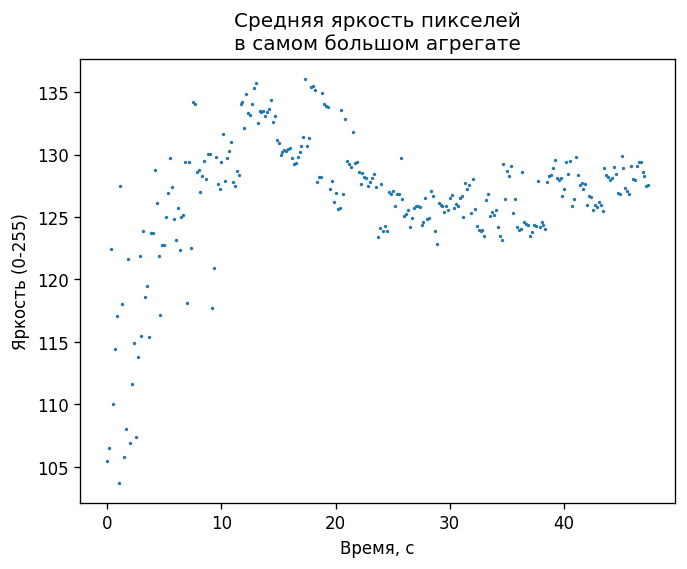

In [ ]:
plt.scatter(times, av_intens, s=1)
plt.title("Средняя яркость пикселей\nв самом большом агрегате")
plt.xlabel("Время, с")
plt.ylabel("Яркость (0-255)")
plt.show()

In [ ]:
cells_num = 3346 # среднее кол-во клеток на изображениях
K = 0

cap = cv2.VideoCapture("1.mp4")
fps = float(cap.get(cv2.CAP_PROP_FPS))
frame_time = 1 / fps
last_frame_i = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
i_frame = 0
step = 5
all_frames_indx = list(range(0, last_frame_i + 1, step))

kernel = np.ones((5,5),np.uint8)

times = np.zeros(len(all_frames_indx))
av_intens = np.zeros(len(all_frames_indx))

i = 0
with tqdm(total=len(all_frames_indx)) as pbar:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print('Видео закончилось')
            break

        if not i_frame in all_frames_indx:
            i_frame += 1
            continue

        original = 255 - cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, image = cv2.threshold(original, 80, 255, cv2.THRESH_BINARY)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

        times[i] = frame_time * i_frame
        pixels = original[image != 0]
        av_intens[i] = np.sum(pixels) / len(pixels)

        i += 1
        i_frame += 1
        pbar.update(1)

  0%|          | 0/285 [00:00<?, ?it/s]

Видео закончилось


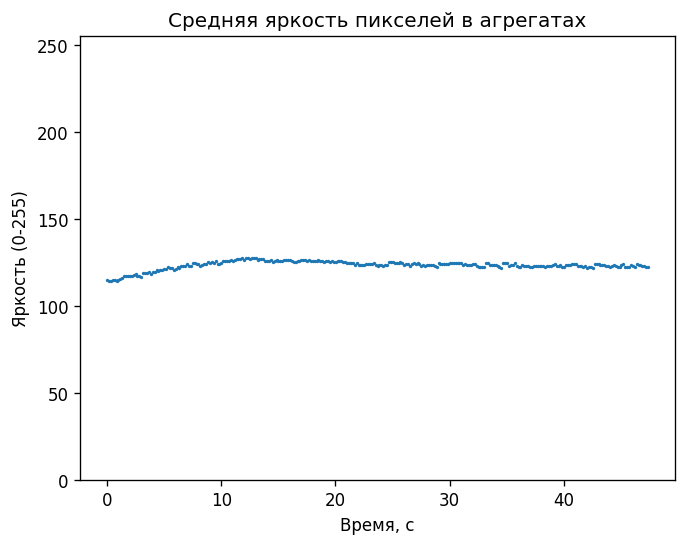

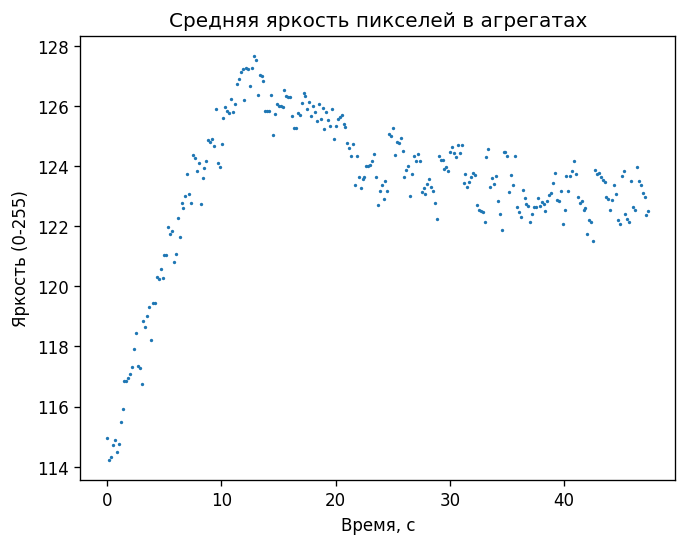

In [ ]:
plt.scatter(times, av_intens, s=1)
plt.title("Средняя яркость пикселей в агрегатах")
plt.xlabel("Время, с")
plt.ylabel("Яркость (0-255)")
plt.ylim((0, 255))
plt.show()

plt.scatter(times, av_intens, s=1)
plt.title("Средняя яркость пикселей в агрегатах")
plt.xlabel("Время, с")
plt.ylabel("Яркость (0-255)")
plt.show()